In [1]:
pip install konlpy -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

1) 데이터 로드하기

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="data-files/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="data-files/ratings_test.txt")

('data-files/ratings_test.txt', <http.client.HTTPMessage at 0x243baa3d050>)

In [4]:
train_data = pd.read_table('data-files/ratings_train.txt')
test_data = pd.read_table('data-files/ratings_test.txt')

In [5]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


2) 데이터 정제하기

In [6]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

label
0    73043
1    72350
Name: count, dtype: int64


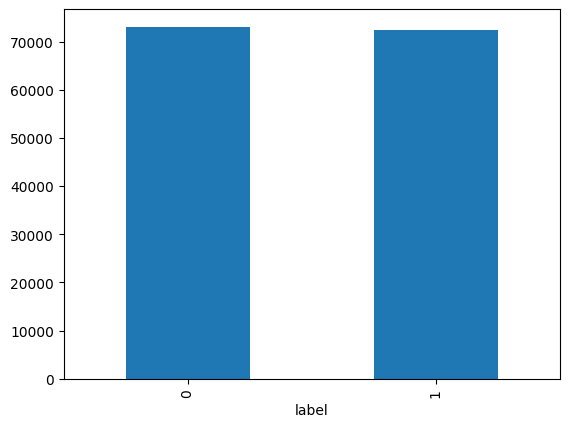

In [70]:
# 부정 / 긍정 비율 시각화 
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data['label'].value_counts())

In [9]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [10]:
print(train_data.isnull().values.any())

True


In [11]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [12]:
# 결측지 확인 
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [13]:
# NaN 포함된 행 전체 제거하고, 모든 컬럼에 NaN이 존재하는지 체크
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
# 한글과 공백을 제외하고 모두 제거
# 영어, 특수문자, 이모지 등 삭제 ex ) 좋아요! :) => 좋아요
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

C:\Users\human\AppData\Local\Temp\ipykernel_18264\718012007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
# 공백정리 & 빈 값 처리 
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) 
# 앞공백 제거. white space 데이터를 empty value로 변경

train_data['document'].replace('', np.nan, inplace=True) # 빈 문자열 NaN 으로 반환 
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


C:\Users\human\AppData\Local\Temp\ipykernel_18264\3966077745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
C:\Users\human\AppData\Local\Temp\ipykernel_18264\3966077745.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to pe

In [16]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [17]:
# 결측지 재처리 
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [18]:
# 위에서 한 train 정제와 동일한 작업을 test에 반복 
# -> 학습/검증 데이터의 전처리 일관성 유지
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


C:\Users\human\AppData\Local\Temp\ipykernel_18264\2256962620.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


3) 토큰화

In [ ]:
# 불용어 정의 
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [20]:
from konlpy.tag import Okt

In [21]:
# 형태소 분석 테스트 
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [22]:
# 훈련 데이터 토큰화 + 불용어 제거 
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)


100%|██████████| 145393/145393 [04:31<00:00, 535.86it/s]


In [25]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


100%|██████████| 48852/48852 [01:41<00:00, 481.15it/s]


4) 학습 데이터, 검증 데이터, 테스트 데이터

In [ ]:
# 라벨 분리 + 학습/검증 분리
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)


In [27]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')


--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


5) 단어 집합 만들기

In [28]:
# 전체 단어 수 집계
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))


총 단어수 : 88276


In [29]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 40264
훈련 데이터에서의 단어 공감의 등장 횟수 : 784


In [30]:
# 등장빈도 상위단어 확인 
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '너무', '정말', '만', '적', '진짜', '으로', '로', '점', '에서']


In [31]:
# 3번 미만 등장한 단어 찾기, 비율 출력 
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 88276
등장 빈도가 2번 이하인 희귀 단어의 수: 60078
단어 집합에서 희귀 단어의 비율: 68.05700303593277
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.644509532507002


In [32]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))


단어 집합의 크기 : 28198


In [33]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1


In [ ]:
# 희귀 단어를 제외한 vocab을 순회하며 정수 인덱스 할당

# +2는 <PAD>(0), <UNK>(1) 예약 토큰 때문

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2


In [35]:
# 최종 단어 집합 크기 출력 
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)


패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 28200


In [36]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])


단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


6) 정수 인코딩

In [ ]:
# 텍스트 → 정수 시퀀스로 변환
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word]) # 단어가 있으면 정수 매핑 
      except KeyError:
          index_sequences.append(word_to_index['<UNK>']) # 없으면 '<UNK>'
    encoded_X_data.append(index_sequences)
  return encoded_X_data


In [ ]:
 # train/valid/test 변환 실행
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)


In [39]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[373, 2422, 7023, 16429]
[9560, 3697, 75, 2346, 544, 24, 1, 615]


In [ ]:
# 인덱스를 다시 단어로 복원
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [41]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)


기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게나', '지루할수가']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게나', '지루할수가']


7) 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.925228261430266


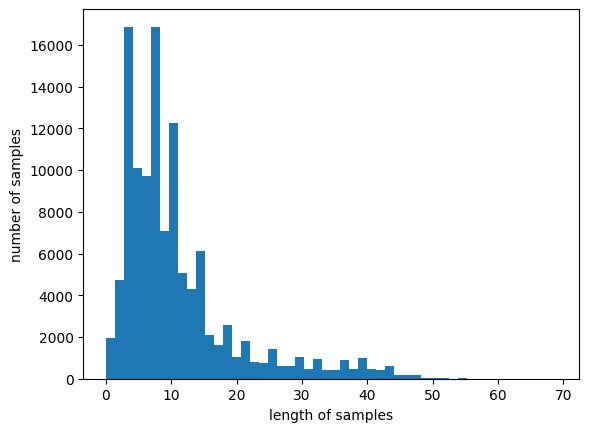

In [42]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [ ]:
# 길이가 max_len보다 짧은 샘플의 비율을 출력 
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [44]:
# max_len=30으로 고정하고 → X_train의 문장들 중 몇 %가 이보다 짧은지 확인
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.11850680055711


In [45]:
# 정수 시퀀스의 길이를 고정된 max_len(30) 으로 맞춰주는 padding 함수
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)


훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [46]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])


첫번째 샘플의 길이 : 30
첫번째 샘플 : [  373  2422  7023 16429     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


2. LSTM을 이용한 네이버 영화 리뷰 분류 모델

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [48]:
# GPU 사용 가능하면 자동으로 CUDA 선택 → 속도 향상
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)


cpu와 cuda 중 다음 기기로 학습함: cpu


In [49]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [51]:
# - 단어 벡터의 차원 = 100
# - 문장 길이 = 500
# - 배치 크기 = 32
# - 데이터 개수 = 2만
# - LSTM의 은닉층의 크기 = 128
# - 분류하고자 하는 카테고리 개수 = 2개


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # 모델은 숫자만 이해하기 때문에 각 단어 정수를 의미를 담은 고차원 벡터로 변환 

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTM Layer : 순차 정보 이해 

        self.fc = nn.Linear(hidden_dim, output_dim)
        # 마지막 hidden state를 받아서 클래스(긍정/부정) 확률로 변환 

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        # 정수 시퀀스를 단어 벡터 시퀀스로 변환 

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)
        #  LSTM 에 넣고 순차 정보 반영한 hidden state 얻기 

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        # 마지막 timestep 의 hidden vector 만 추출 (문장의미 요약 )

        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        # → 긍정/부정 확률 score 계산 
        
        return logits


In [ ]:
# 학습 데이터를 PyTorch가 이해할 수 있도록 TensorDataset 형태로 바꿔주고,
# DataLoader로 미니배치로 학습할 수 있도록 구성 (shuffle: 데이터 순서 섞음)

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)


In [54]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 3635


In [55]:
embedding_dim = 100 # 단어 벡터 차원 
hidden_dim = 128 # LSTM의 기억 크기
output_dim = 2 #  긍정/부정 → 2개
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)


TextClassifier(
  (embedding): Embedding(28200, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류에 적합
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam → 학습 성능 좋은 최적화 알고리즘

3. 평가 코드 작성

In [ ]:
# 예측값과 실제값 비교해 정확도 계산 
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
# 검증 성능 평가 함수
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


4. 학습

In [59]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/5:
Train Loss: 0.4882, Train Accuracy: 0.7417
Validation Loss: 0.3821, Validation Accuracy: 0.8242
Validation loss improved from inf to 0.3821. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.3289, Train Accuracy: 0.8557
Validation Loss: 0.3526, Validation Accuracy: 0.8434
Validation loss improved from 0.3821 to 0.3526. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.2598, Train Accuracy: 0.8910
Validation Loss: 0.3650, Validation Accuracy: 0.8437
Epoch 4/5:
Train Loss: 0.1998, Train Accuracy: 0.9198
Validation Loss: 0.4032, Validation Accuracy: 0.8407
Epoch 5/5:
Train Loss: 0.1462, Train Accuracy: 0.9437
Validation Loss: 0.4424, Validation Accuracy: 0.8397


단계           | 코드 내용                     | 설명
--------------|------------------------------|---------------------------------------------
학습 모드 설정 | model.train()               | 드롭아웃 등 학습 전용 설정 활성화
순전파         | logits = model(batch_X)     | 입력 데이터로 예측값 생성
손실 역전파     | loss.backward()             | 실제값과 예측값의 오차를 기반으로 기울기 계산
최적화         | optimizer.step()            | 기울기를 반영해 모델 파라미터 업데이트
검증 평가       | evaluate(...)               | 검증 데이터셋으로 손실 및 정확도 평가
모델 저장       | torch.save(...)             | 검증 손실이 감소하면 모델 체크포인트 저장

5. 모델 로드 및 평가

In [60]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

TextClassifier(
  (embedding): Embedding(28200, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [61]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 0.3526
Best model validation accuracy: 0.8434


In [62]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3604
Best model test accuracy: 0.8399


6. 모델 테스트

In [ ]:
# 예측 함수 정의
 
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


In [66]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)


'긍정'

In [67]:
test_input = "이딴게 영화냐 ㅉㅉ"
predict(test_input, model, word_to_index, index_to_tag)


'부정'

In [71]:
test_input = "너무 재미있어"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [68]:
# word_to_index 저장
with open("word_to_index.pkl", "wb") as f:
    pickle.dump(word_to_index, f)

# index_to_tag 저장
with open("index_to_tag.pkl", "wb") as f:
    pickle.dump(index_to_tag, f)